In [1]:
cd ..

/home/mars/src_aiai


In [2]:
from src.util import gpu_setup
gpu_setup()

8 actual GPUs, 1 in use.


2022-03-03 15:38:21.260582: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 15:38:22.125707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14635 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

In [5]:
from src.networks.UNet import UNet
from src.operators.NUFFT2D_TF import NUFFT2D_TF
from src.sampling.uv_sampling import spider_sampling, random_sampling

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [6]:
from src.visualisation import compare

In [7]:
x = np.load("./data/intermediate/COCO/NUFFT_Random/x_true_train_30dB.npy")
y = np.load("./data/intermediate/COCO/NUFFT_Random/y_dirty_train_30dB.npy")

# x = np.load("./data/intermediate/COCO/NUFFT_SPIDER/x_true_train_30dB.npy")
# y = np.load("./data/intermediate/COCO/NUFFT_SPIDER/y_dirty_train_30dB.npy")

In [8]:
Nd = (256,256)
Kd = (512,512)
Jd = (6,6)

In [9]:
uv = random_sampling(Nd[0]**2//2)
m_op = NUFFT2D_TF()
m_op.plan(uv, Nd, Kd, Jd, 1)

100%|██████████| 32768/32768 [00:04<00:00, 7017.31it/s]


some values lie out of the interpolation array, these are not used, check baselines


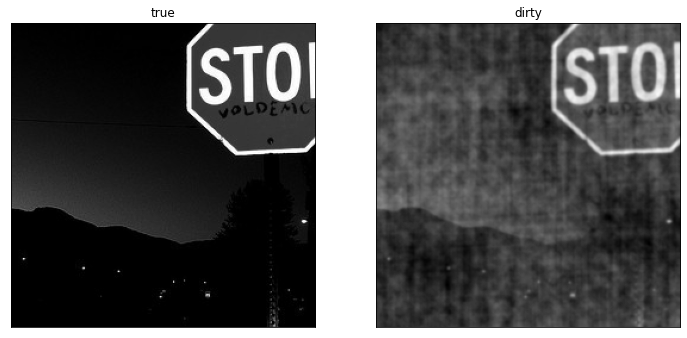

In [10]:
i = 5
a = x[i]
b = tf.math.real(m_op.adj_op(y[i].reshape(1,-1)))[0].numpy().real
compare([a,b], cmap='gray', titles=['true', 'dirty'])

# Load trained denoiser

In [27]:
denoiser = UNet(
    Nd, 
    uv=None,
    op=None, 
    depth=4, 
    input_type="image", 
    measurement_weights=1,
    batch_size=1
    )

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_1/AddV2:0', description="created by layer 'tf.__operators__.add_1'")


In [28]:
latest = tf.train.latest_checkpoint("./models/COCO/Identity/UNet_30dB")
denoiser.load_weights(latest)


# Looking at denoising power of denoiser

In [46]:
i = 8

In [47]:
ISNR = 30
sigma = np.sqrt(np.mean(np.abs(x[i])**2)) * 10**(-ISNR/20)
n = np.random.normal( 0, sigma, x[i].shape) #+ 1j * np.random.normal( 0, sigma, x[0].shape)

In [48]:
sigma

0.020001485138684653

In [49]:
5/255 ,15/255, 40/255

(0.0196078431372549, 0.058823529411764705, 0.1568627450980392)

In [50]:
x_dirty = x[i] + n

In [51]:
x_dirty = (x_dirty - x_dirty.min())/(x_dirty.max() - x_dirty.min())

In [52]:
x_denoised = denoiser(x_dirty[np.newaxis, :])

In [53]:
x_denoised = x_denoised *(x_dirty.max() - x_dirty.min()) + x_dirty.min()

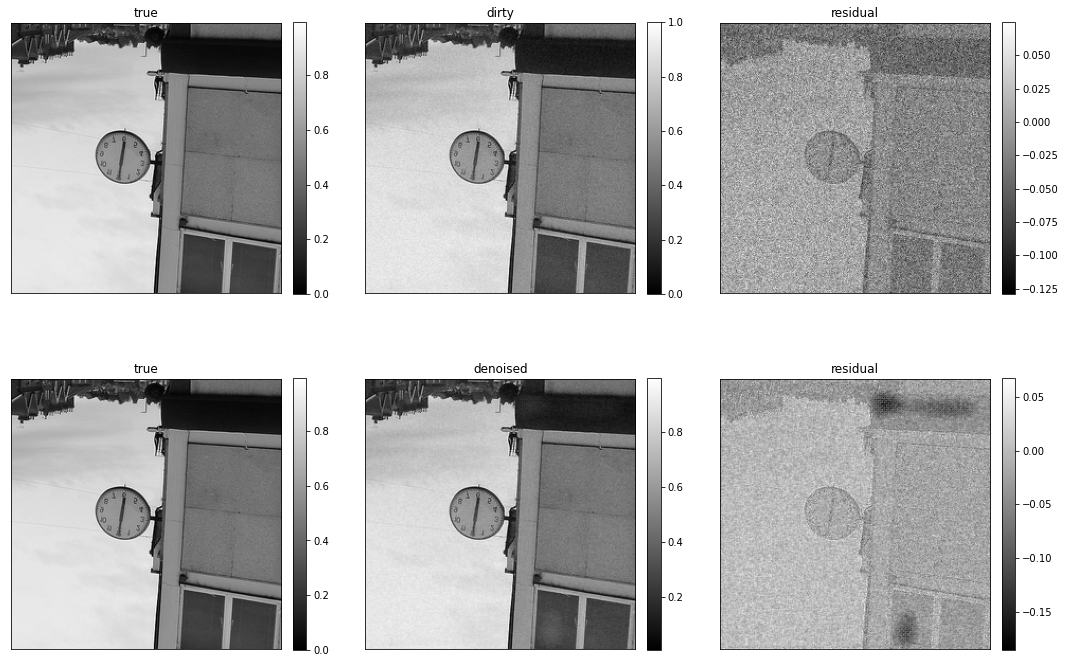

In [54]:
compare([x[i], x_dirty.real, x[i]-x_dirty.real, x[i], x_denoised[0], x[i] -x_denoised[0]], nrows=2, ncols=3, same_scale=False, cmap='gray', colorbar=True, titles=["true", "dirty", "residual", "true", "denoised", "residual"])

In [77]:
mse = lambda x,y: np.mean(np.square(x-y))

In [ ]:
rms(x[i], x_dirty), rms(x_true, x_denoised)

# Looking at denoising power of denoiser on pseudo-inverse images

In [55]:
x_dirty2 = m_op.adj_op((y[i].reshape(1,-1)).astype(np.complex64))

In [56]:
c = x_dirty2.numpy().real[0]

c = (c - c.min()) / (c.max()-c.min())

In [57]:
x_denoised2 = denoiser(c[np.newaxis,:])

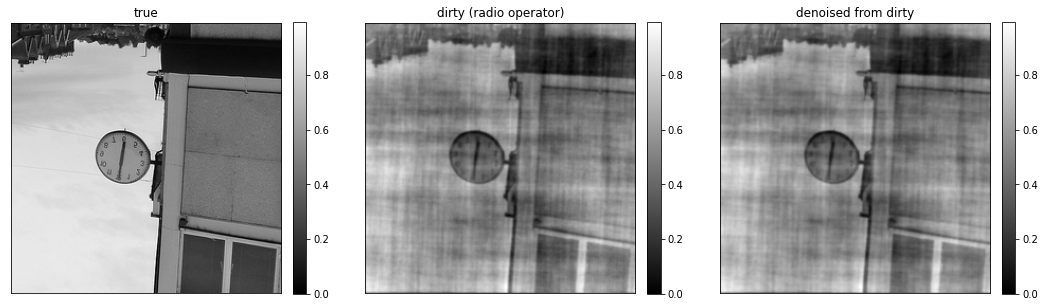

In [62]:
compare([x[i], c, x_denoised2.numpy().real[0]], nrows=1, ncols=3, same_scale=True, cmap='gray', colorbar=True, titles=["true", "dirty (radio operator)", "denoised from dirty"])

# Gradient descent

In [63]:
class Gradient(tf.keras.layers.Layer):
    """
    Gradient operator
    TODO create docstring
    """
    def __init__(self, m_op, shape_x, shape_y, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    

    def __call__(self, x, y, measurement_weights=1):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.dir_op(x) 
        res = m -  y
        grad = self.m_op.adj_op( res  * measurement_weights)
        grad = tf.cast(grad, tf.float32)
        return grad

In [64]:
grad = Gradient(m_op, Nd, (m_op.n_measurements,), 0)

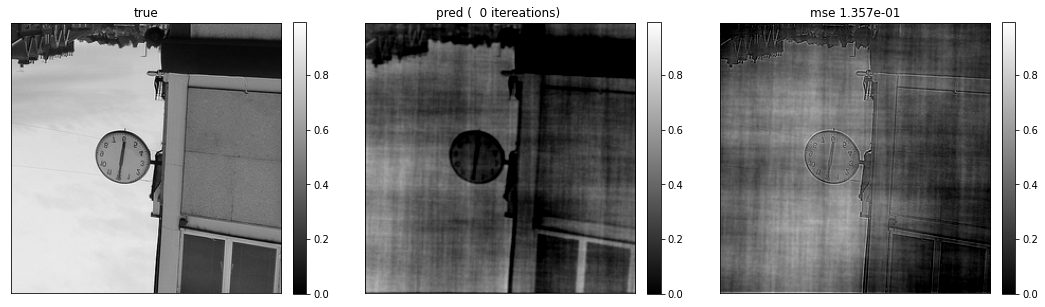

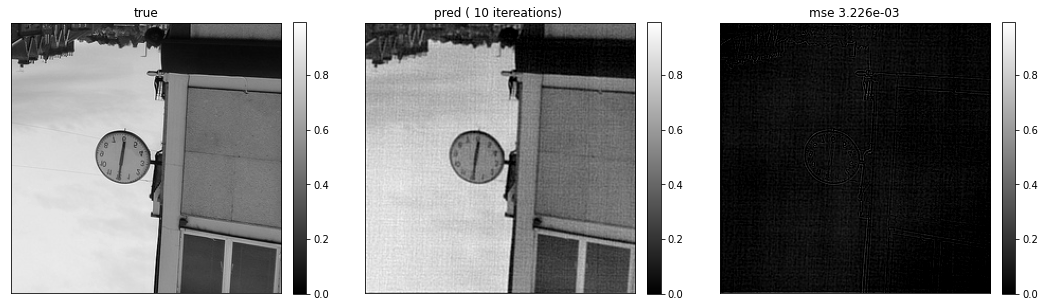

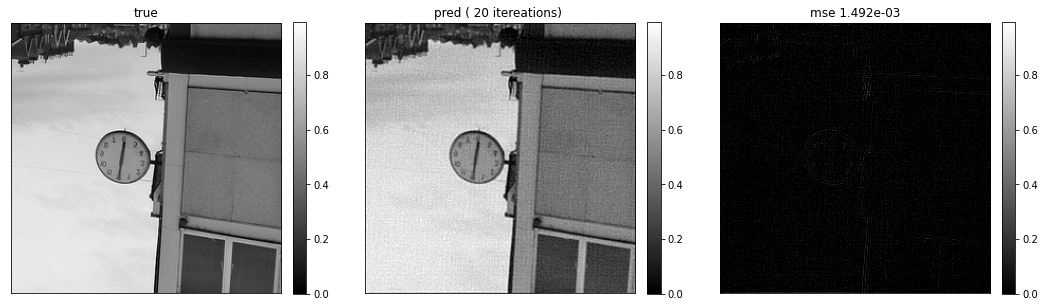

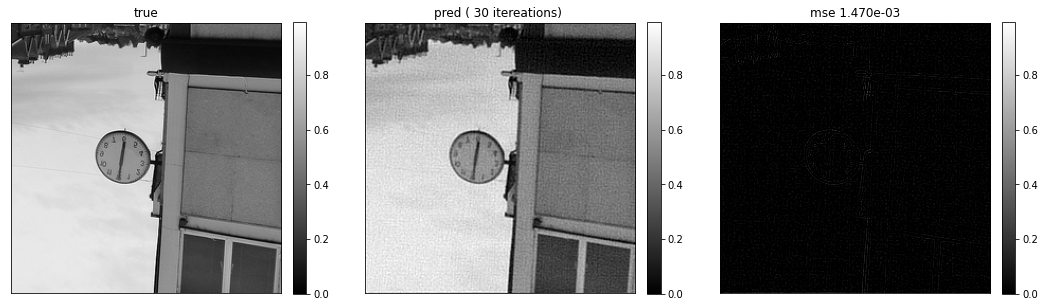

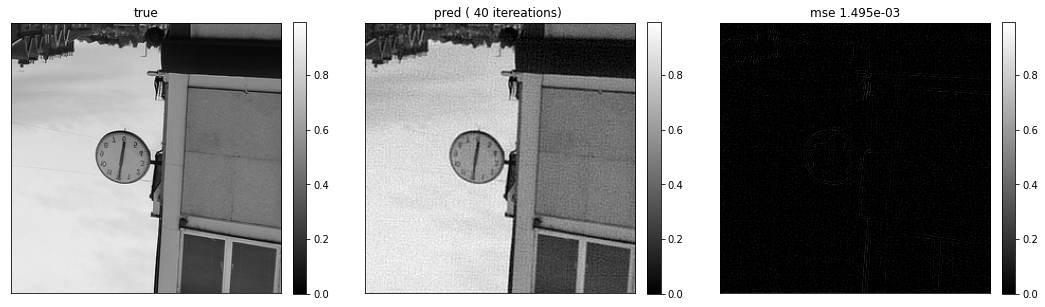

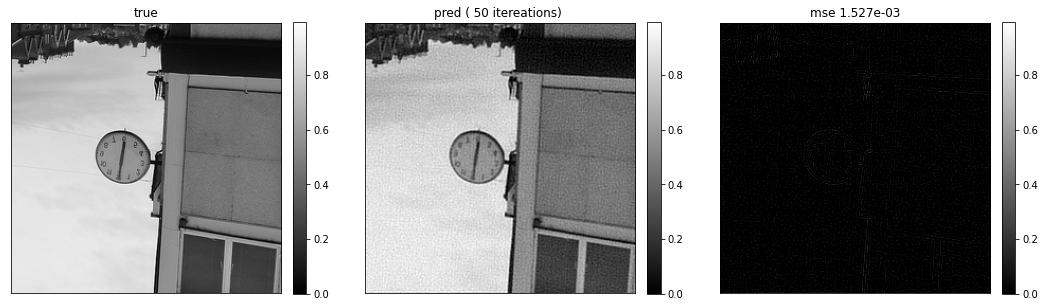

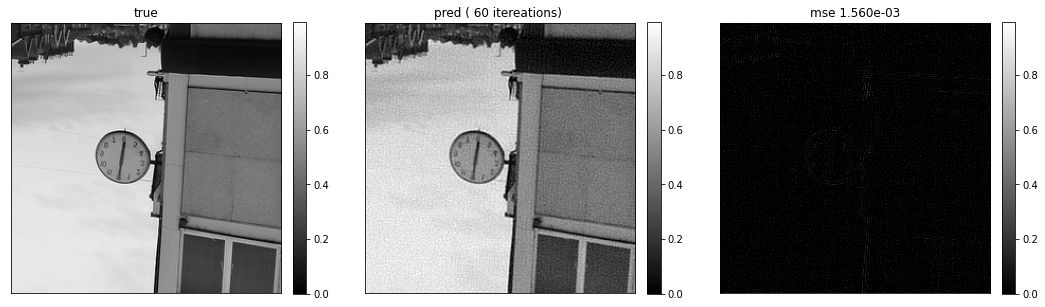

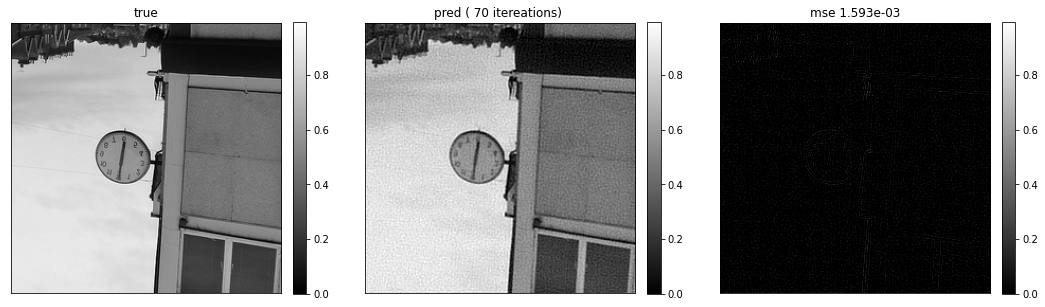

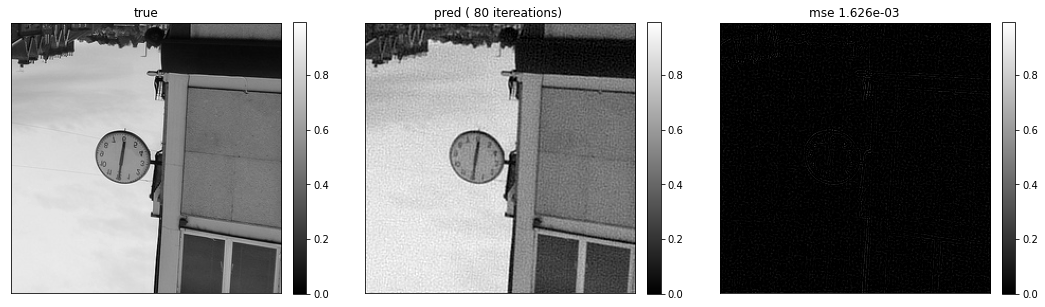

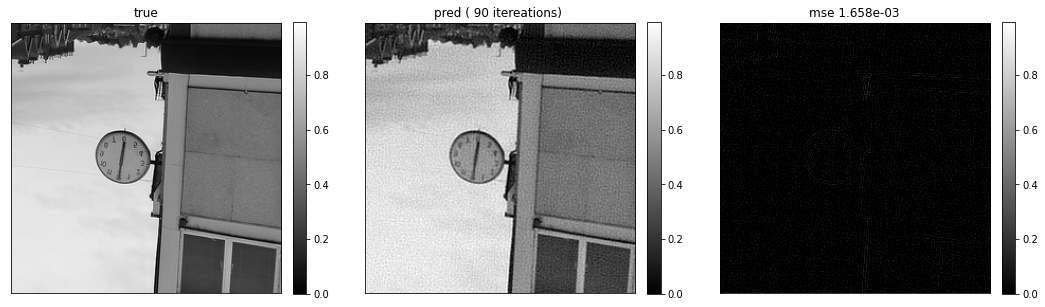

In [78]:
# gradient descent
x_ = tf.math.real(m_op.adj_op(y[i].reshape(1,-1)))
a = 1
for j in range(100):
    g = grad(x_, y[i])[0]
    x_ = x_ - a * g
    if j%10 ==0 :
        compare([x[i], x_.numpy().real[0], x[i]-x_.numpy().real[0]], cmap='gray', titles=["true", f"pred ({j:>3} itereations) ", f"mse {mse(x[i], x_.numpy().real[0]):.3e}"], colorbar=True, same_scale=True)


# Gradient descent + denoiser

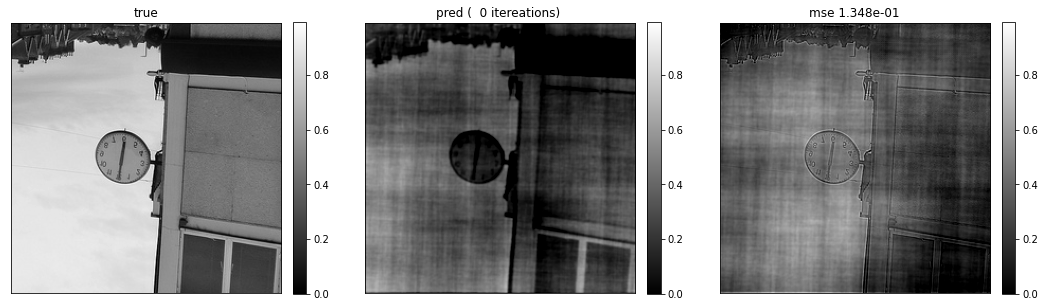

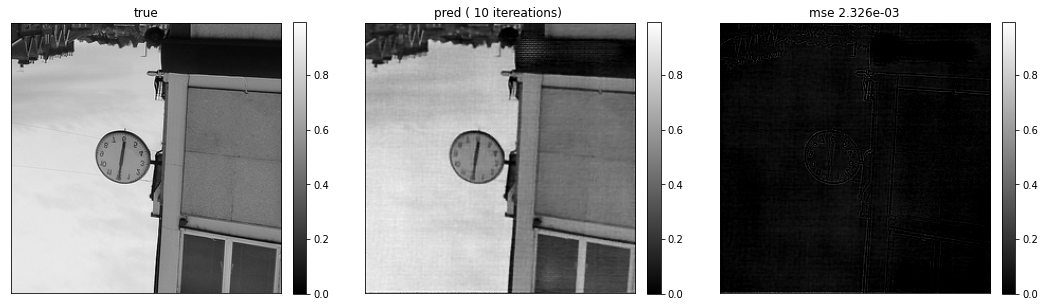

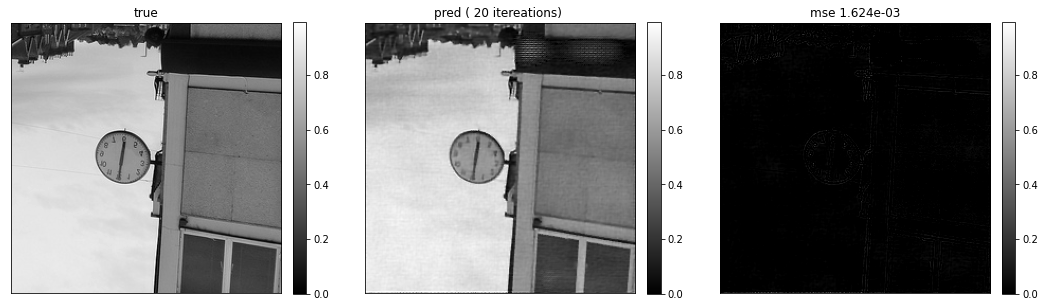

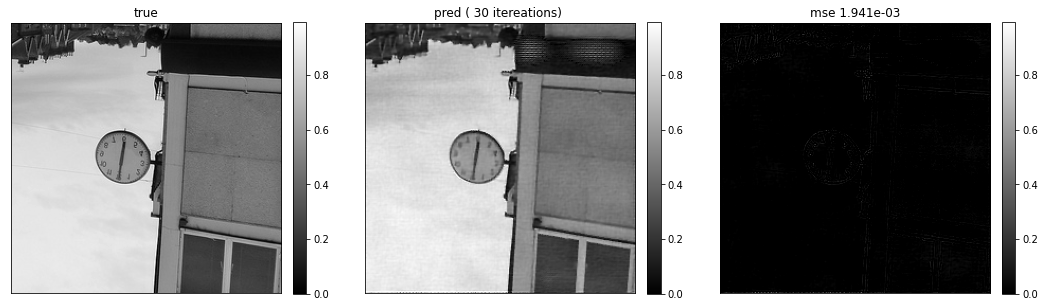

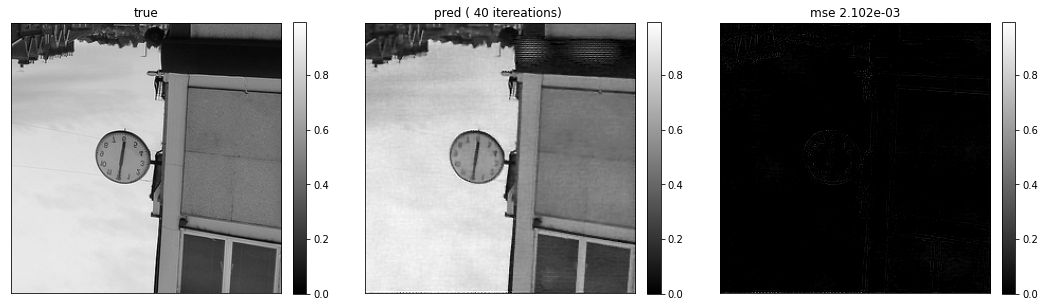

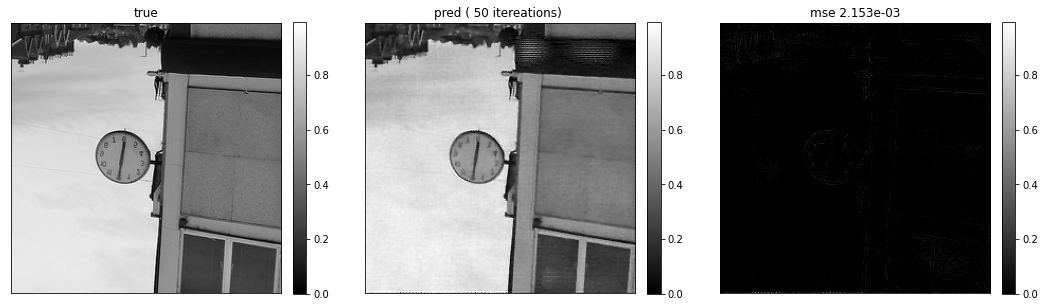

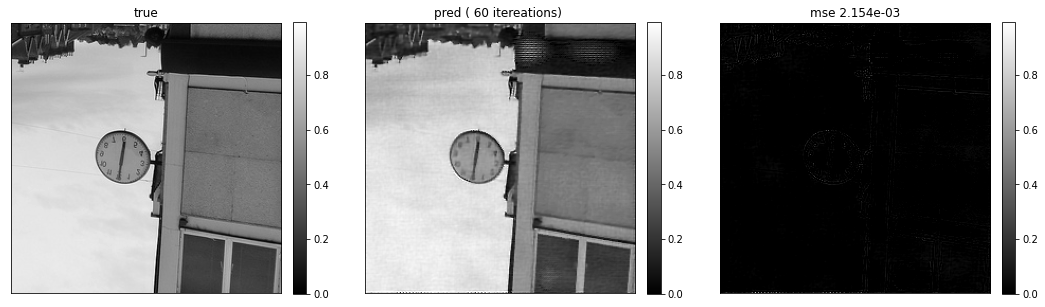

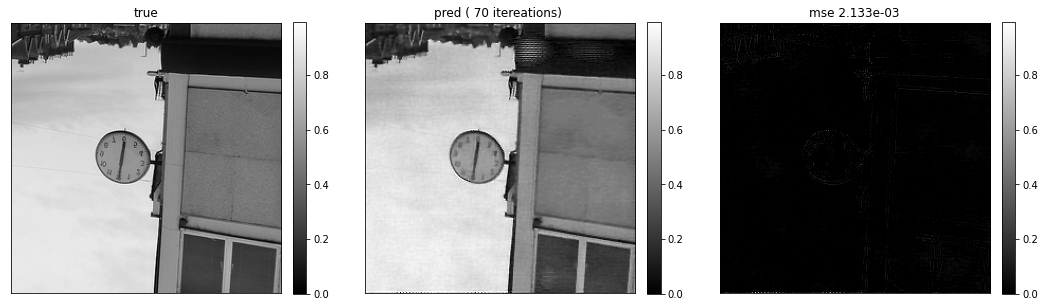

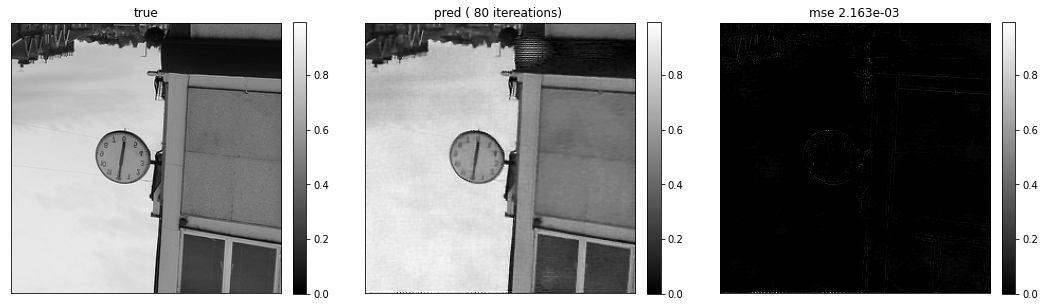

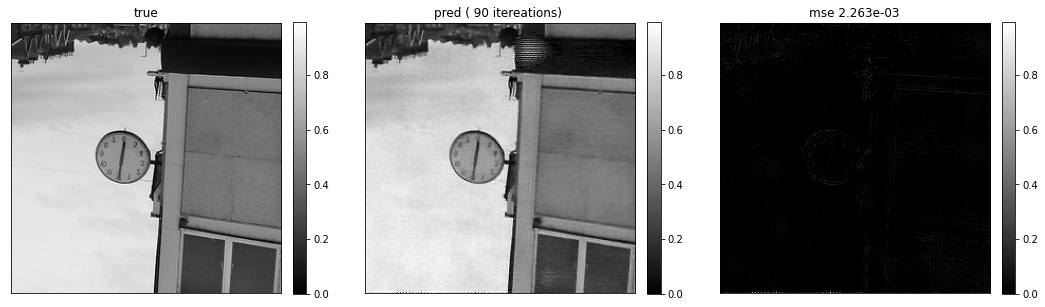

In [79]:

x_ = tf.math.real(m_op.adj_op(y[i].reshape(1,-1)))
a = 1
for j in range(100):
    g = grad(x_, y[i])[0]
    x_ = x_ - a * g
    
    # rescale to be within (0,1) for the denoiser
    
    x_ = x_.numpy()
    mintmp, maxtmp = x_.min(), x_.max()
    x_ = (x_ - mintmp)/(maxtmp - mintmp) 
    
    scale_range = 1.0 + sigma/2.0
    scale_shift = (1 - scale_range) / 2.0
    x_ = x_ * scale_range + scale_shift
    
    
    x_ = denoiser(x_)
    
    # undo scaling
    x_ = (x_ - scale_shift)/scale_range
    x_ = x_ * (maxtmp - mintmp) + mintmp
    
    if j % 10 == 0:
        compare([x[i], x_.numpy().real[0], x[i]-x_.numpy().real[0]], cmap='gray', titles=["true", f"pred ({j:>3} itereations) ", f"mse {mse(x[i], x_.numpy().real[0]):.3e}"], colorbar=True, same_scale=True)
